CLUSTERING PROCESS

In [ ]:
# Imports + file list + load
import pandas as pd
import numpy as np
from pathlib import Path

files = {
    "Jakarta": "Jakarta_clean_hourly.csv",
    "Bangkok": "Bangkok_clean_hourly.csv",
    "Tokyo":   "Tokyo_clean_hourly.csv",
    "Berlin":  "Berlin_clean_hourly.csv",
    "London":  "London_clean_hourly.csv",
    "Moscow":  "Moscow_clean_hourly.csv"
}

dfs = []
for city, fn in files.items():
    p = Path(fn)
    if not p.exists():
        print(f"Warning: {fn} not found, skipping {city}.")
        continue
    df = pd.read_csv(p, parse_dates=["datetime"] if "datetime" in pd.read_csv(p, nrows=0).columns else [])
    df = df.copy()
    df["city"] = city
    dfs.append(df)

if not dfs:
    raise RuntimeError("No files loaded. Check filenames and working directory.")
combined = pd.concat(dfs, ignore_index=True)
print("Loaded combined shape:", combined.shape)
combined.head()


Loaded combined shape: (263088, 13)


,datetime,date,pm10,pm2_5,ammonia,carbon_monoxide,nitrogen_dioxide,carbon_dioxide,sulphur_dioxide,methane,missing_pollutants,city,n_missing_pollutants
0,2020-12-01 00:00:00+00:00,2020-12-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,Jakarta,NaN
1,2020-12-01 01:00:00+00:00,2020-12-01 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,Jakarta,NaN
2,2020-12-01 02:00:00+00:00,2020-12-01 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,Jakarta,NaN
3,2020-12-01 03:00:00+00:00,2020-12-01 03:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,Jakarta,NaN
4,2020-12-01 04:00:00+00:00,2020-12-01 04:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,Jakarta,NaN


In [ ]:
# Canonical pollutant detection and normalize column names
# canonical names we will use
canonical = ["pm10","pm2_5","ammonia","carbon_monoxide",
             "nitrogen_dioxide","carbon_dioxide","sulphur_dioxide","methane"]

# normalize combined column names to lowercase/no spaces/dots
combined.columns = [c.strip().lower().replace(" ", "_").replace(".", "_") for c in combined.columns]

# build mapping for common pm2.5 variants
col_map = {}
for c in combined.columns:
    c_norm = c.lower()
    if c_norm in canonical:
        col_map[c] = c_norm
    # handle pm2.5 / pm25 variants
    elif c_norm.replace(".", "_") in canonical:
        col_map[c] = c_norm.replace(".", "_")
    elif c_norm.replace(".", "") in [x.replace("_","") for x in canonical]:
        # e.g., pm25 -> pm2_5
        for p in canonical:
            if c_norm.replace(".","").replace("_","") == p.replace("_",""):
                col_map[c] = p

if col_map:
    combined = combined.rename(columns=col_map)

# final pollutant list available
pollutants = [p for p in canonical if p in combined.columns]
print("Detected pollutant columns:", pollutants)
if not pollutants:
    raise RuntimeError("No pollutant columns found. Check file columns.")


Detected pollutant columns: ['pm10', 'pm2_5', 'ammonia', 'carbon_monoxide', 'nitrogen_dioxide', 'carbon_dioxide', 'sulphur_dioxide', 'methane']


In [ ]:
# Drop totally missing pollutants and quick missing diagnostics
# drop pollutants that are NaN across the entire combined dataset
all_nan = [p for p in pollutants if combined[p].isna().all()]
if all_nan:
    print("Dropping all-NaN pollutants:", all_nan)
    combined = combined.drop(columns=all_nan)
    pollutants = [p for p in pollutants if p not in all_nan]

# show missing counts / fraction
miss_cnt = combined[pollutants].isna().sum()
miss_pct = 100 * miss_cnt / len(combined)
missing_df = pd.DataFrame({"missing_count": miss_cnt, "missing_pct": miss_pct.round(2)})
display(missing_df.sort_values("missing_pct", ascending=False))


,missing_count,missing_pct
methane,205164,77.98
carbon_dioxide,205164,77.98
ammonia,131544,50.00
pm10,43974,16.71
carbon_monoxide,43974,16.71
pm2_5,43974,16.71
nitrogen_dioxide,43974,16.71
sulphur_dioxide,43974,16.71


In [ ]:
# Imputation (KNN) and scaling
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import StandardScaler

X = combined[pollutants].copy()

USE_KNN = True  # set False to use SimpleImputer(mean)

if USE_KNN:
    # scale temporarily on median-filled data to get good neighbor distances
    X_temp = X.fillna(X.median())
    tmp_scaler = StandardScaler()
    X_temp_scaled = tmp_scaler.fit_transform(X_temp)

    knn = KNNImputer(n_neighbors=5, weights="uniform")
    X_knn_scaled = knn.fit_transform(X_temp_scaled)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_knn_scaled)
else:
    imputer = SimpleImputer(strategy="mean")
    X_imp = imputer.fit_transform(X)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_imp)

print("Imputation + scaling done. Any NaNs left:", np.isnan(X_scaled).any())


Imputation + scaling done. Any NaNs left: False


Explained variance ratio (first components): [0.515 0.163 0.126]


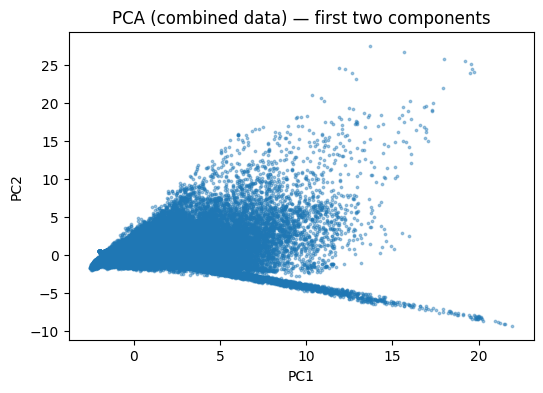

In [ ]:
# PCA (for speed and visualization)
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

DO_PCA = True
PCA_N = 3

if DO_PCA:
    pca = PCA(n_components=PCA_N, random_state=42)
    X_pca = pca.fit_transform(X_scaled)
    print("Explained variance ratio (first components):", np.round(pca.explained_variance_ratio_, 3))

    plt.figure(figsize=(6,4))
    if PCA_N >= 2:
        plt.scatter(X_pca[:,0], X_pca[:,1], s=3, alpha=0.4)
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.title("PCA (combined data) — first two components")
    else:
        plt.plot(X_pca[:,0], ".", ms=1)
    plt.show()
else:
    X_pca = X_scaled

k=2, inertia=243872.97
k=3, inertia=221498.62
k=4, inertia=176779.51
k=5, inertia=143145.10
k=6, inertia=118039.13
k=7, inertia=104517.05
k=8, inertia=95031.65


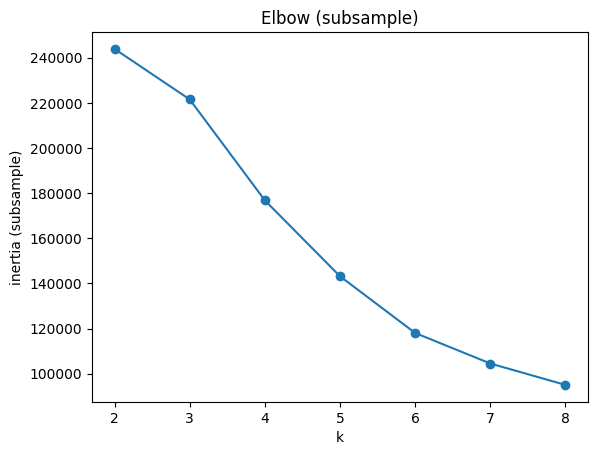

In [ ]:
# fast elbow (subsample) using MiniBatchKMeans
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt

X_for_elbow = X_pca  # fast
frac = 0.25
rng = np.random.RandomState(42)
n_sample = max(2000, int(len(X_for_elbow)*frac))
idx = rng.choice(len(X_for_elbow), size=n_sample, replace=False)
X_sample = X_for_elbow[idx]

Ks = range(2,9)
inertias = []
for k in Ks:
    mb = MiniBatchKMeans(n_clusters=k, batch_size=2048, random_state=42, max_iter=200, n_init=3)
    mb.fit(X_sample)
    inertias.append(mb.inertia_)
    print(f"k={k}, inertia={mb.inertia_:.2f}")

plt.plot(list(Ks), inertias, marker='o')
plt.xlabel("k")
plt.ylabel("inertia (subsample)")
plt.title("Elbow (subsample)")
plt.show()


In [ ]:
# Final clustering on data
from sklearn.cluster import MiniBatchKMeans

k_final = 4
CLUSTER_ON_PCA = True  # True-> use X_pca; False-> use X_scaled

X_final = X_pca if CLUSTER_ON_PCA else X_scaled

model = MiniBatchKMeans(n_clusters=k_final, batch_size=2048, random_state=42, max_iter=300, n_init=5)
labels = model.fit_predict(X_final)
combined["cluster"] = labels

# save full results
combined.to_csv("global_clusters_all_cities.csv", index=False)
print("Saved global_clusters_all_cities.csv")
print("Cluster counts:")
print(combined["cluster"].value_counts().sort_index())


Saved global_clusters_all_cities.csv
Cluster counts:
cluster
0     18779
1    208459
2      7201
3     28649
Name: count, dtype: int64


##Random Cluster Metric Testing

In [ ]:
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)
import numpy as np

rng = np.random.RandomState(42)
sample_size = 10000
idx = rng.choice(len(X_pca), size=sample_size, replace=False)

X_sample = X_pca[idx]

results = []

for k in [3, 4]:
    model = MiniBatchKMeans(
        n_clusters=k,
        batch_size=2048,
        random_state=42,
        max_iter=300,
        n_init=5
    )

    labels_k = model.fit_predict(X_sample)

    sil = silhouette_score(X_sample, labels_k)
    dbi = davies_bouldin_score(X_sample, labels_k)
    ch  = calinski_harabasz_score(X_sample, labels_k)

    results.append((k, sil, dbi, ch))

for k, sil, dbi, ch in results:
    print(
        f"k={k} | "
        f"Silhouette={sil:.3f} | "
        f"Davies–Bouldin={dbi:.3f} | "
        f"Calinski–Harabasz={ch:.1f}"
    )

k=3 | Silhouette=0.517 | Davies–Bouldin=1.130 | Calinski–Harabasz=5718.2
k=4 | Silhouette=0.548 | Davies–Bouldin=0.921 | Calinski–Harabasz=5323.5


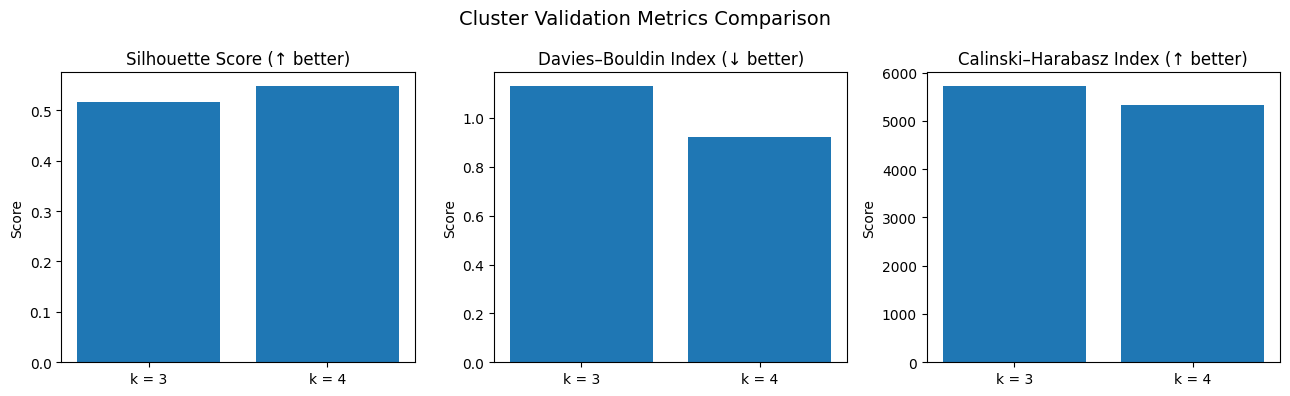

In [ ]:
import matplotlib.pyplot as plt

# Metric values from results
ks = ["k = 3", "k = 4"]

silhouette_scores = [0.517, 0.548]
davies_bouldin_scores = [1.130, 0.921]
calinski_harabasz_scores = [5718.2, 5323.5]

# Figures
fig, axes = plt.subplots(1, 3, figsize=(13, 4))

# Silhouette
axes[0].bar(ks, silhouette_scores)
axes[0].set_title("Silhouette Score (↑ better)")
axes[0].set_ylabel("Score")

# Davies Bouldin
axes[1].bar(ks, davies_bouldin_scores)
axes[1].set_title("Davies–Bouldin Index (↓ better)")
axes[1].set_ylabel("Score")

# Calinski Harabasz
axes[2].bar(ks, calinski_harabasz_scores)
axes[2].set_title("Calinski–Harabasz Index (↑ better)")
axes[2].set_ylabel("Score")

# Layout
plt.suptitle("Cluster Validation Metrics Comparison", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
# Cluster profiles and city + cluster distribution + percentage distribution
polls = [p for p in pollutants if p in combined.columns]
cluster_profiles = combined.groupby("cluster")[polls].mean().round(3)
city_cluster_counts = combined.groupby(["city","cluster"]).size().unstack(fill_value=0)
city_cluster_pct = city_cluster_counts.div(city_cluster_counts.sum(axis=1), axis=0).multiply(100).round(2)

cluster_profiles.to_csv("global_cluster_profiles.csv")
city_cluster_counts.to_csv("city_cluster_counts.csv")
city_cluster_pct.to_csv("city_cluster_pct.csv")

print("Cluster profiles (means):")
display(cluster_profiles)
print("City x Cluster counts:")
display(city_cluster_counts)
print("City x Cluster % distribution:")
display(city_cluster_pct)

Cluster profiles (means):


,pm10,pm2_5,ammonia,carbon_monoxide,nitrogen_dioxide,carbon_dioxide,sulphur_dioxide,methane
cluster,,,,,,,,
0,28.378,21.696,4.443,333.790,40.650,468.086,18.648,1513.685
1,19.826,14.529,1.361,321.806,23.550,455.733,12.302,1493.580
2,64.815,58.042,2.777,2101.359,68.869,517.244,64.737,2013.433
3,89.144,64.979,3.048,1969.985,78.541,468.035,53.680,1620.144


City x Cluster counts:


cluster,0,1,2,3
city,,,,
Bangkok,0,37598,743,5507
Berlin,3739,39963,146,0
Jakarta,0,25594,2371,15883
London,8647,34862,339,0
Moscow,6393,32465,2431,2559
Tokyo,0,37977,1171,4700


City x Cluster % distribution:


cluster,0,1,2,3
city,,,,
Bangkok,0.00,85.75,1.69,12.56
Berlin,8.53,91.14,0.33,0.00
Jakarta,0.00,58.37,5.41,36.22
London,19.72,79.51,0.77,0.00
Moscow,14.58,74.04,5.54,5.84
Tokyo,0.00,86.61,2.67,10.72


In [ ]:
# Asia vs Europe
asia = ["Jakarta","Bangkok","Tokyo"]
europe = ["Berlin","London","Moscow"]

combined["region"] = combined["city"].apply(lambda x: "Asia" if x in asia else "Europe")
region_profile = combined.groupby("region")[polls].mean().round(3)
region_profile.to_csv("region_profile_asia_vs_europe.csv")

print("Region mean pollutant table (Asia vs Europe):")
display(region_profile)

# Quick difference (Asia - Europe)
diff = (region_profile.loc["Asia"] - region_profile.loc["Europe"]).round(3)
print("Asia minus Europe (positive => higher in Asia):")
display(diff)

Region mean pollutant table (Asia vs Europe):


,pm10,pm2_5,ammonia,carbon_monoxide,nitrogen_dioxide,carbon_dioxide,sulphur_dioxide,methane
region,,,,,,,,
Asia,48.334,35.905,NaN,1115.110,47.786,468.760,29.508,1588.959
Europe,19.628,14.691,1.865,251.781,24.315,462.517,13.635,1555.399


Asia minus Europe (positive => higher in Asia):


,0
pm10,28.706
pm2_5,21.214
ammonia,NaN
carbon_monoxide,863.329
nitrogen_dioxide,23.471
carbon_dioxide,6.243
sulphur_dioxide,15.873
methane,33.560


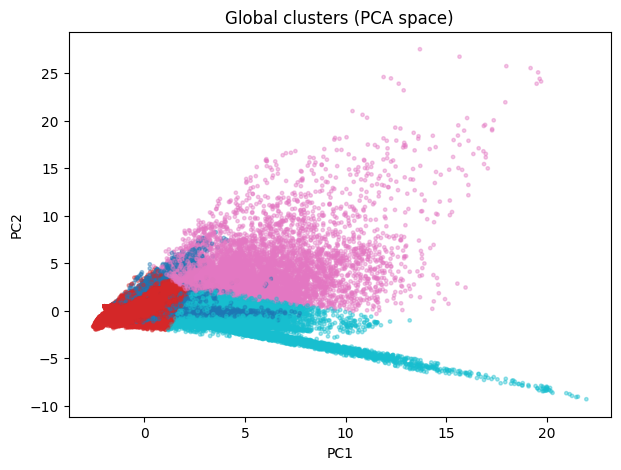

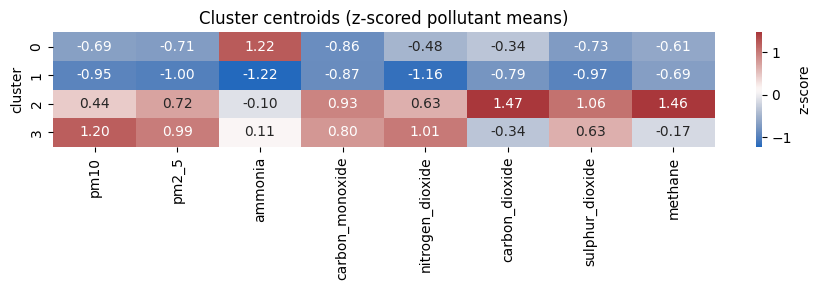

In [ ]:
# PCA scatter + heatmap of cluster centroids
import matplotlib.pyplot as plt
import seaborn as sns

# PCA scatter
if CLUSTER_ON_PCA:
    plt.figure(figsize=(7,5))
    plt.scatter(X_pca[:,0], X_pca[:,1], c=labels, s=6, cmap="tab10", alpha=0.4)
    plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("Global clusters (PCA space)")
    plt.show()

# heatmap of z-scored cluster profiles for readability
z = (cluster_profiles - cluster_profiles.mean()) / cluster_profiles.std()
plt.figure(figsize=(9,3))
sns.heatmap(z, annot=True, fmt=".2f", cmap="vlag", cbar_kws={"label":"z-score"})
plt.title("Cluster centroids (z-scored pollutant means)")
plt.ylabel("cluster")
plt.tight_layout()
plt.show()

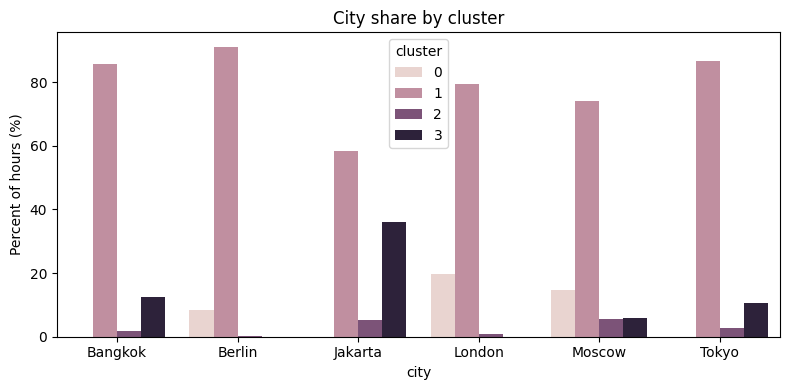

/tmp/ipython-input-2470674154.py:14: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  monthly = combined.groupby([combined["datetime"].dt.to_period("M"), "cluster"]).size().unstack(fill_value=0)


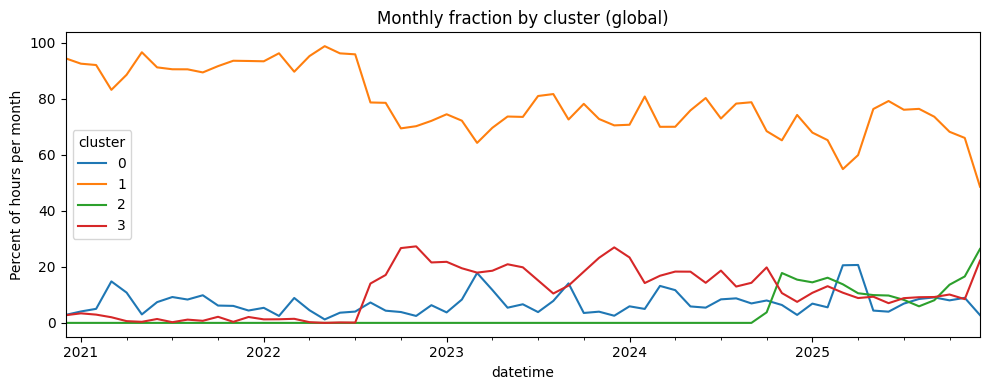

In [ ]:
# Temporal and ciry analysis examples
# Fraction of hours by cluster per city (bar chart)
city_cluster_pct = city_cluster_pct.reset_index().melt(id_vars="city", var_name="cluster", value_name="pct")
plt.figure(figsize=(8,4))
sns.barplot(data=city_cluster_pct, x="city", y="pct", hue="cluster")
plt.ylabel("Percent of hours (%)")
plt.title("City share by cluster")
plt.legend(title="cluster")
plt.tight_layout()
plt.show()

# Monthly frequency of one cluster (example)
combined["datetime"] = pd.to_datetime(combined["datetime"])
monthly = combined.groupby([combined["datetime"].dt.to_period("M"), "cluster"]).size().unstack(fill_value=0)
monthly_frac = monthly.div(monthly.sum(axis=1), axis=0).multiply(100)
monthly_frac.plot(kind="line", figsize=(10,4))
plt.ylabel("Percent of hours per month")
plt.title("Monthly fraction by cluster (global)")
plt.legend(title="cluster")
plt.tight_layout()
plt.show()

CLUSTERING PROCESS (HIERARCHICAL CLUSTERING)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

In [ ]:
# Asia
jakarta = pd.read_csv("Jakarta_clean_hourly.csv")
bangkok = pd.read_csv("Bangkok_clean_hourly.csv")
tokyo = pd.read_csv("Tokyo_clean_hourly.csv")

# Europe
berlin = pd.read_csv("Berlin_clean_hourly.csv")
london = pd.read_csv("London_clean_hourly.csv")
moscow = pd.read_csv("Moscow_clean_hourly.csv")

# Add city names
jakarta["city"] = "Jakarta"
bangkok["city"] = "Bangkok"
tokyo["city"] = "Tokyo"
berlin["city"] = "Berlin"
london["city"] = "London"
moscow["city"] = "Moscow"

In [ ]:
# combining all datasets
df = pd.concat([jakarta, bangkok, tokyo, berlin, london, moscow], ignore_index=True)
print(df.shape)
df.head()

(263088, 13)


,datetime,date,pm10,pm2_5,ammonia,carbon_monoxide,nitrogen_dioxide,carbon_dioxide,sulphur_dioxide,methane,missing_pollutants,city,n_missing_pollutants
0,2020-12-01 00:00:00+00:00,2020-12-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,Jakarta,NaN
1,2020-12-01 01:00:00+00:00,2020-12-01 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,Jakarta,NaN
2,2020-12-01 02:00:00+00:00,2020-12-01 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,Jakarta,NaN
3,2020-12-01 03:00:00+00:00,2020-12-01 03:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,Jakarta,NaN
4,2020-12-01 04:00:00+00:00,2020-12-01 04:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,Jakarta,NaN


In [ ]:
# Select pollutant columns
pollutant_cols = [
    'pm10', 'pm2_5', 'carbon_monoxide', 'nitrogen_dioxide',
    'carbon_dioxide', 'sulphur_dioxide', 'methane'
]

In [ ]:
# Impute missing values properly
df[pollutant_cols] = df[pollutant_cols].fillna(df[pollutant_cols].mean())

In [ ]:
# Standardize pollutant values
scaler = StandardScaler()
X = scaler.fit_transform(df[pollutant_cols])

City means (used for hierarchical):


,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,carbon_dioxide,sulphur_dioxide,methane
city,,,,,,,
Bangkok,43.345466,31.587306,853.410432,30.817038,461.303398,16.171508,1601.077118
Berlin,14.069520,10.179740,210.078818,13.629373,457.275016,2.100110,1437.995908
Jakarta,67.823441,51.279058,2154.864354,62.143052,466.254143,41.898099,1702.474829
London,13.929020,9.549319,186.757144,21.076768,458.406256,3.157310,1466.853066
Moscow,30.884584,24.345135,358.505707,38.237845,471.870934,35.648955,1761.348249
Tokyo,33.834018,24.847945,337.056355,50.398136,478.722706,30.453808,1463.324011


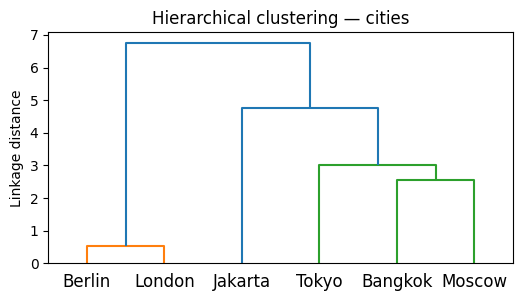

,pm10,pm2_5,carbon_monoxide,nitrogen_dioxide,carbon_dioxide,sulphur_dioxide,methane,cluster
city,,,,,,,,
Bangkok,43.345466,31.587306,853.410432,30.817038,461.303398,16.171508,1601.077118,2
Berlin,14.069520,10.179740,210.078818,13.629373,457.275016,2.100110,1437.995908,1
Jakarta,67.823441,51.279058,2154.864354,62.143052,466.254143,41.898099,1702.474829,2
London,13.929020,9.549319,186.757144,21.076768,458.406256,3.157310,1466.853066,1
Moscow,30.884584,24.345135,358.505707,38.237845,471.870934,35.648955,1761.348249,2
Tokyo,33.834018,24.847945,337.056355,50.398136,478.722706,30.453808,1463.324011,2


In [ ]:
# Hierarchical on city-level pollutant means
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import matplotlib.pyplot as plt

# load saved combined if you have it, otherwise build from files
try:
    combined = pd.read_csv("global_clusters_all_cities.csv", parse_dates=["datetime"])
except Exception:
    # fallback: load the six clean hourly files and concat (adjust paths if needed)
    files = {
        "Jakarta": "Jakarta_clean_hourly.csv",
        "Bangkok": "Bangkok_clean_hourly.csv",
        "Tokyo":   "Tokyo_clean_hourly.csv",
        "Berlin":  "Berlin_clean_hourly.csv",
        "London":  "London_clean_hourly.csv",
        "Moscow":  "Moscow_clean_hourly.csv"
    }
    dfs = []
    for city, fn in files.items():
        try:
            df = pd.read_csv(fn, parse_dates=["datetime"])
            df["city"] = city
            dfs.append(df)
        except FileNotFoundError:
            pass
    combined = pd.concat(dfs, ignore_index=True)

# choose pollutant columns that exist
pollutants = [c for c in ["pm10","pm2_5","carbon_monoxide","nitrogen_dioxide",
                          "carbon_dioxide","sulphur_dioxide","methane"] if c in combined.columns]

# compute city means
df_city = combined.groupby("city")[pollutants].mean()
print("City means (used for hierarchical):")
display(df_city)

# clean & scale
dfc = df_city.replace([np.inf, -np.inf], np.nan).fillna(df_city.median())
X = StandardScaler().fit_transform(dfc.values)

# linkage & dendrogram
Z = linkage(X, method="ward")
plt.figure(figsize=(6,3))
dendrogram(Z, labels=dfc.index.tolist(), leaf_font_size=12)
plt.title("Hierarchical clustering — cities")
plt.ylabel("Linkage distance")
plt.show()

# optional cluster labels
from scipy.cluster.hierarchy import fcluster
labels = fcluster(Z, t=2, criterion="maxclust")
df_city["cluster"] = labels
display(df_city)

In [ ]:
# Simple rule-based interpreter to generate short textual summaries per cluster
def interpret_cluster_means(row):
    texts = []
    # thresholds are coarse — adjust to your units/typical ranges if needed
    if "pm2_5" in row.index and (row["pm2_5"] > 40 or row.get("pm10",0) > 60):
        texts.append("High fine particulate (PM2.5/PM10) — haze/smoke or dust")
    if "nitrogen_dioxide" in row.index and row["nitrogen_dioxide"] > 40:
        texts.append("High NO₂ — traffic/combustion influence")
    if "carbon_monoxide" in row.index and row["carbon_monoxide"] > 5:
        texts.append("Elevated CO — combustion/vehicle emissions")
    if "sulphur_dioxide" in row.index and row["sulphur_dioxide"] > 10:
        texts.append("Elevated SO₂ — industrial/fuel combustion source")
    if "methane" in row.index and row["methane"] > 2000:
        texts.append("High CH₄ — methane sources (waste/agriculture/leaks)")
    if "carbon_dioxide" in row.index and row["carbon_dioxide"] > 450:
        texts.append("Elevated CO₂ — dense urban activity")
    if not texts:
        return "Low-to-moderate pollution (background)"
    return "; ".join(texts)

interpretations = {}
for cl in sorted(df_city["cluster"].unique()):
    profile = df_city[df_city["cluster"]==cl].drop(columns="cluster").mean()
    interpretations[cl] = interpret_cluster_means(profile)

# print nicely
for cl, text in interpretations.items():
    print(f"Cluster {cl}: {text}")


Cluster 1: Elevated CO — combustion/vehicle emissions; Elevated CO₂ — dense urban activity
Cluster 2: High NO₂ — traffic/combustion influence; Elevated CO — combustion/vehicle emissions; Elevated SO₂ — industrial/fuel combustion source; Elevated CO₂ — dense urban activity


Quick guide to interpretation & writing up
The dendrogram shows which cities are most similar and at what distance. Short branch = more similar pollutant fingerprints.

- df_city table (with cluster column) tells you each city’s assigned cluster — that’s your main Asia vs Europe mapping.

- Use the heatmap (z-scored) to report which pollutants are above or below the 6-city mean (positive z → higher than mean).

In report, include:

- a one-sentence cluster name (e.g., “Cluster 1 — PM‑dominated (haze)”) from CELL 5,

- a short paragraph per cluster describing likely sources (traffic, industry, biomass burning), and

- a city table showing percent of time (or number of hours) each city spends in each cluster (for hourly analyses you can compute percent-of-hours per cluster for each city; for city-means you just show assignment).

We applied hierarchical clustering (Ward linkage) to city-level mean pollution profiles across six cities (Jakarta, Bangkok, Tokyo, Berlin, London, Moscow). The analysis identified N clusters. Cluster 1 is characterized by high NO₂ and elevated CO₂ and is therefore interpreted as traffic-dominated urban conditions; Cluster 2 shows elevated PM2.5/PM10 consistent with haze or particulate pollution; Cluster 3 shows elevated SO₂ and CO consistent with industrial emissions, and Cluster 4 reflects low-to-moderate background pollution. Jakarta primarily falls into Cluster X, Bangkok into Cluster Y, and European cities (Berlin/London/Moscow) fall into Cluster Z, indicating [brief interpretation of Asia vs Europe differences].